# MAPK8IP3
[neurodevelopmental disorder with or without variable brain abnormalities (NEDBA)](https://omim.org/entry/618443) is caused by heterozygous mutation in the MAPK8IP3 gene.

In [2]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.2.dev0


## MAPK8IP3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [3]:
gene_symbol = 'MAPK8IP3'
mane_tx_id = 'NM_001318852.2'
mane_protein_id = 'NP_001305781.1' # C-Jun-amino-terminal kinase-interacting protein 3 isoform 3

### Phenopackets
We loaded a cohort of 20 phenopackets representing published descriptions of individuals with pathogenic variants in MAPK8IP3 diagnosed with NEDBA.

In [4]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.19'  # Update, if necessary
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

print(f'Loaded {len(phenopackets)} phenopackets')

Loaded 20 phenopackets


In [5]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

Individuals Processed: 100%|██████████| 20/20 [00:00<00:00, 701.90individuals/s]
Loaded 20 individuals
Validated under permissive policy
No errors or warnings were found


In [6]:
from gpsea.view import ProteinVariantViewer
from gpsea.preprocessing import configure_default_protein_metadata_service
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
cpd_viewer = ProteinVariantViewer(tx_id=mane_tx_id, protein_metadata=protein_meta)

In [8]:
html = cpd_viewer.process(cohort=cohort)
html


Name,Type,Coordinates,Count,Variants
RH1,DOMAIN,12 - 100,4,p.Tyr15Ter; p.Glu27Ter; p.Gly22AlafsTer3; p.Tyr37Ter
Kinesin-binding domain (KBD); essential for its function in axon elongation,REGION,50 - 80,0,
Disordered,REGION,182 - 211,0,
JNK-binding domain (JBD); essential for its function in axon elongation,REGION,209 - 225,0,
Disordered,REGION,243 - 318,0,
Leucine zipper-like domain (LZ); essential for its function in axon elongation,REGION,423 - 458,2,p.Leu445Pro
Interaction with NTRK2,REGION,458 - 514,0,
RH2,DOMAIN,520 - 594,7,p.Arg579Cys; p.Arg526Gln
Disordered,REGION,719 - 766,0,
Disordered,REGION,879 - 969,0,


# Explorative analysis
todo

In [9]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
report

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,19
Hypotonia,HP:0001252,11
Thin corpus callosum,HP:0033725,9
"Intellectual disability, moderate",HP:0002342,7
Intellectual disability,HP:0001249,6
Spastic diplegia,HP:0001264,6
Delayed ability to walk,HP:0031936,6
Seizure,HP:0001250,6
Cerebral atrophy,HP:0002059,5
Thin upper lip vermilion,HP:0000219,5


In [10]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

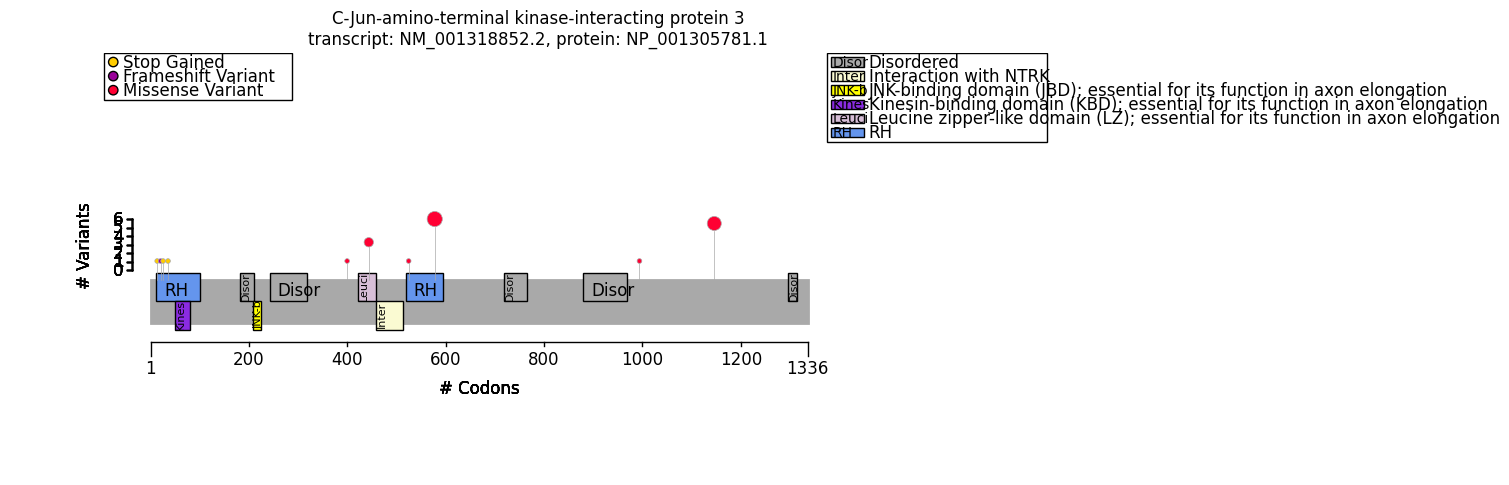

In [11]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

# Strategy
todo

In [13]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

n_term = VariantPredicates.region(region=Region(0, 600), tx_id=mane_tx_id)
gt_predicate = autosomal_dominant(n_term)

In [14]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [15]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
report

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,2
HMF02,Skipping term because no genotype has more than one observed HPO count,2
HMF04,Skipping term because all genotypes have same HPO observed proportions,23
HMF06,Skipping term with less than 7 observations (not powered for 2x2),95
HMF08,Skipping general term,44


In [16]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group              HOM_REF  ...          
                                          Count  ...  p values
Prominent nasal bridge [HP:0000426]         3/3  ...  0.142857
Cerebral visual impairment [HP:0100704]     2/3  ...  0.142857
Short philtrum [HP:0000322]                 2/3  ...  0.142857
Anteverted nares [HP:0000463]               2/3  ...  0.142857
Spastic diplegia [HP:0001264]               2/3  ...  0.428571
Autistic behavior [HP:0000729]              2/2  ...  0.428571
Gait disturbance [HP:0001288]               2/3  ...  0.545455
Seizure [HP:0001250]                        1/6  ...  0.600032
Inability to walk [HP:0002540]              1/3  ...  1.000000
Thin corpus callosum [HP:0033725]           3/3  ...  1.000000
Hypotonia [HP:0001252]                      4/6  ...  1.000000
Cerebral palsy [HP:0100021]                 1/4  ...  1.000000

[12 rows x 6 columns]

In [16]:
#16_1762843_1762843_C_T	c.1735C>T	p.Arg579Cys	MISSENSE_VARIANT
#16_1767834_1767834_C_T	c.3439C>T	p.Arg1147Cys	MISSENSE_VARIANT

In [17]:
# 16_1762843_1762843_C_T = c.1735C>T; p.Arg579Cys
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
is_var_key = VariantPredicates.variant_key("16_1762843_1762843_C_T")
gt_predicate = monoallelic_predicate(
    a_predicate=is_var_key,
    b_predicate= ~is_var_key,
    names=('p.Arg287Trp', 'Other variant')
)
gt_predicate.display_question()

'Allele group: p.Arg287Trp, Other variant'

In [19]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Allele group                        p.Arg287Trp  ...          
                                          Count  ...  p values
Seizure [HP:0001250]                        4/5  ...  0.021709
Inability to walk [HP:0002540]              3/3  ...  0.024242
Autistic behavior [HP:0000729]              0/3  ...  0.028571
Gait disturbance [HP:0001288]               3/3  ...  0.060606
Hypotonia [HP:0001252]                      2/5  ...  0.325980
Thin corpus callosum [HP:0033725]           6/6  ...  0.400000
Spastic diplegia [HP:0001264]               4/4  ...  0.428571
Short philtrum [HP:0000322]                 0/3  ...  0.428571
Anteverted nares [HP:0000463]               0/3  ...  0.428571
Prominent nasal bridge [HP:0000426]         1/3  ...  0.485714
Autism [HP:0000717]                         0/5  ...  0.523810
Cerebral palsy [HP:0100021]                 1/4  ...  1.000000

[12 rows x 6 columns]

In [20]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)

In [21]:
pvv.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
RH1,DOMAIN,12 - 100,4,p.Tyr15Ter; p.Glu27Ter; p.Gly22AlafsTer3; p.Tyr37Ter
Kinesin-binding domain (KBD); essential for its function in axon elongation,REGION,50 - 80,0,
Disordered,REGION,182 - 211,0,
JNK-binding domain (JBD); essential for its function in axon elongation,REGION,209 - 225,0,
Disordered,REGION,243 - 318,0,
Leucine zipper-like domain (LZ); essential for its function in axon elongation,REGION,423 - 458,2,p.Leu445Pro
Interaction with NTRK2,REGION,458 - 514,0,
RH2,DOMAIN,520 - 594,7,p.Arg579Cys; p.Arg526Gln
Disordered,REGION,719 - 766,0,
Disordered,REGION,879 - 969,0,


In [31]:
from gpsea.analysis.predicate.genotype import ProteinPredicates

ppreds = ProteinPredicates(protein_metadata_service=protein_meta)
rh2 = ppreds.protein_feature(feature_id="RH2", tx_id=mane_tx_id)
rh2.get_question()
rh2_monoallelic_predicate = monoallelic_predicate(
    a_predicate=rh2,
    b_predicate= ~rh2,
    names=('RH2', 'Other region')
)
gt_predicate.display_question()

'Allele group: RH2, Other region'

In [32]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=rh2_monoallelic_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

AttributeError: 'ProteinMetadata' object has no attribute 'annotate'

In [21]:
display(HTML(html))

Name,Type,Coordinates,Count,Variants
RH1,DOMAIN,12 - 100,4,p.Gly22AlafsTer3; p.Tyr37Ter; p.Tyr15Ter; p.Glu27Ter
Kinesin-binding domain (KBD); essential for its function in axon elongation,REGION,50 - 80,0,
Disordered,REGION,182 - 211,0,
JNK-binding domain (JBD); essential for its function in axon elongation,REGION,209 - 225,0,
Disordered,REGION,243 - 318,0,
Leucine zipper-like domain (LZ); essential for its function in axon elongation,REGION,423 - 458,2,p.Leu445Pro
Interaction with NTRK2,REGION,458 - 514,0,
RH2,DOMAIN,520 - 594,7,p.Arg526Gln; p.Arg579Cys
Disordered,REGION,719 - 766,0,
Disordered,REGION,879 - 969,0,


In [22]:
pp = ProteinPredicates(protein_meta)
lz = pp.protein_feature("Leucine zipper-like domain (LZ); essential for its function in axon elongation", tx_id=mane_tx_id)
lz.get_question()

'Variant that affects Leucine zipper-like domain (LZ); essential for its function in axon elongation feature on the protein encoded by transcript NM_001318852.2'

In [23]:
gt_predicate = gpsea.analysis.predicate.genotype.autosomal_dominant(lz)

In [24]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
result.total_tests

AttributeError: 'ProteinMetadata' object has no attribute 'annotate'

In [33]:
from gpsea.analysis.predicate.genotype import sex_predicate
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
from gpsea.view import summarize_hpo_analysis
summary_df = summarize_hpo_analysis(hpo, result)
summary_df

Sex of the individual                   FEMALE  ...          
                                         Count  ...  p values
Cerebral visual impairment [HP:0100704]    2/3  ...  0.142857
Short philtrum [HP:0000322]                2/3  ...  0.142857
Anteverted nares [HP:0000463]              2/3  ...  0.142857
Autism [HP:0000717]                        0/7  ...  0.466667
Gait disturbance [HP:0001288]              2/3  ...  0.545455
Inability to walk [HP:0002540]             1/3  ...  1.000000
Thin corpus callosum [HP:0033725]          5/5  ...  1.000000
Spastic diplegia [HP:0001264]              3/3  ...  1.000000
Hypotonia [HP:0001252]                     5/9  ...  1.000000
Autistic behavior [HP:0000729]             1/2  ...  1.000000
Prominent nasal bridge [HP:0000426]        2/3  ...  1.000000
Cerebral palsy [HP:0100021]                1/4  ...  1.000000

[12 rows x 6 columns]